<a href="https://colab.research.google.com/github/cclljj/LJ-test/blob/master/4_2_%E6%99%82%E5%BA%8F%E8%B3%87%E6%96%99%E9%A0%90%E6%B8%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

前一章節介紹了各種處理時序資料的方法，有視覺化呈現資料、時序資料分解......等，經過處理後的資料可以讓我們更進一步的運用，擁有過去的資料後，會想要預知未來，因此本章節將會判斷時序資料的特性以及使用多種預測模型找出資料的的模式，藉此預測未來。

章節目標


*   時序資料特性的判斷：平穩性
*   學習各種預測模型並進行比較
*   使用時序資料進行訓練與預測





此章節主要使用到的套件有:

1.   kats: 用來分析時序資料的套件，功能包括偵測、預測、特徵擷取等
2.   statsmodels: 統計相關的套件，功能包括統計檢驗、分析、預測
3.   pmdarima: 統計相關套件，用來分析時序資料的平穩性、週期性、預測，功能與R語言的auto.arima相似

剩下的套件會協助主要套件對資料的處理，功能就不一一做說明，而這些套件在一開始都要先安裝與引入。



# Install Packages

In [ ]:
!pip install --upgrade pip

# Kats
!pip install kats==0.1 ax-platform==0.2.3 statsmodels==0.12.2

# pmdarima
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 5.1 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 47.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.3/934.3 kB 41.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 361.8/361.8 kB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 326.0/326.0 kB 30.7 MB/s eta 0:00:00
  Created wheel for kats: filename=ka

# Import Packages

In [ ]:
import warnings
import numpy as np
import pandas as pd
import pmdarima as pm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss
from kats.consts import TimeSeriesData, TimeSeriesIterator
from kats.models.prophet import ProphetModel, ProphetParams
from kats.models.lstm import LSTMModel, LSTMParams
from kats.models.holtwinters import HoltWintersParams, HoltWintersModel

# 讀取資料(Read Data)

首先一樣先拿取一個測站長時間的空品資料，將資料存成datafram的格式並取名為air，這些資料會以時間作為索引且依照時間排序，方便我們做後續資料的處理。

如果想要查看資料，可以使用以下方法：


1.   air.info()顯示dataframe的相關資訊
2.   air.head()顯示此dataframe的前五筆資料
3.   air.tail()顯示此dataframe的後五筆資料



In [ ]:
air = pd.read_csv("./drive/MyDrive/AS/Time-Series/yunlin-longtime.csv", parse_dates=['timestamp'], index_col="timestamp")
air.info()
air.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 241367 entries, 2022-07-21 00:00:29 to 2021-02-28 23:58:32
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  241367 non-null  int64  
 1   index       241367 non-null  int64  
 2   device_id   241367 non-null  object 
 3   siteName    0 non-null       float64
 4   PM25        241367 non-null  float64
 5   SiteName    232331 non-null  object 
dtypes: float64(2), int64(2), object(2)
memory usage: 12.9+ MB


,Unnamed: 0,index,device_id,siteName,PM25,SiteName
timestamp,,,,,,
2022-07-21 00:00:29,0,0,74DA38C7D2AC,NaN,3.0,雲林縣立平和國小(2017)
2022-07-21 00:06:30,1,1,74DA38C7D2AC,NaN,3.0,雲林縣立平和國小(2017)
2022-07-21 00:12:32,2,2,74DA38C7D2AC,NaN,2.0,雲林縣立平和國小(2017)
2022-07-21 00:18:33,3,3,74DA38C7D2AC,NaN,2.0,雲林縣立平和國小(2017)
2022-07-21 00:24:34,4,4,74DA38C7D2AC,NaN,3.0,雲林縣立平和國小(2017)


因為我們只需要時間與PM25這兩個欄位(column)的資料，因此先將其他欄位的資料刪除，並將資料以時間排序

In [ ]:
air.drop(columns=['Unnamed: 0', 'index', 'device_id', 'siteName', 'SiteName'], inplace=True)
air.sort_values(by='timestamp', inplace=True)
air.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 241367 entries, 2018-08-01 00:00:05 to 2022-07-31 23:56:21
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   PM25    241367 non-null  float64
dtypes: float64(1)
memory usage: 3.7 MB


接著讀取水位資料，也是重複上述的操作，將資料存成成datafram的格式並取名為water

In [ ]:
water = pd.read_csv("./drive/MyDrive/AS/Time-Series/water1.csv", parse_dates=['timestamp'], index_col="timestamp")
water.info()
water.head()

將資料中不需要的欄位(column)刪除，並將資料以時間排序

In [ ]:
water.drop(columns=['Unnamed: 0', 'station_id', 'ciOrgname', 'ciCategory', 'Organize_Name', 'CategoryInfos_Name', 'PQ_name', 'PQ_fullname', 'PQ_description', 'PQ_unit', 'PQ_id'], inplace=True)
water.sort_values(by='timestamp', inplace=True)
water.info()

再讀取氣象資料，仍然是重複上述的操作，將資料存成成datafram的格式並取名為climate

In [ ]:
climate = pd.read_csv("./drive/MyDrive/AS/Time-Series/climate1.csv", parse_dates=['obsTime'], index_col="obsTime")
climate.info()
climate.head()

將資料中不需要的欄位(column)刪除，並將資料以時間排序

In [ ]:
climate.drop(columns=['Unnamed: 0'], inplace=True)
climate.sort_values(by='obsTime', inplace=True)
climate.info()

到這邊我們已經成功讀入資料，現在有三個dataframe，分邊是叫作air(空品資料)、water(水資源資料)、climate(氣象資料)。

# 預處理(Preprocess)

使用4.1的方法先重新採樣，將資料點取每小時平均(air_hour)、每天平均(air_day)、每月平均(air_month)

In [ ]:
air_hour = air.resample('H').mean()
air_day = air.resample('D').mean()
air_month = air.resample('M').mean()
# air_hour.fill(inplace=True)
# air_day.ffill(inplace=True)
# air_month.ffill(inplace=True)

## 離群值(Outlier)

使用4.1處理離群值的方法，因為這章節主要使用的是air_hour的資料，因此我們先將這當中的離群值移除

In [ ]:
from kats.detectors.outlier import OutlierDetector
air_hour_ts = TimeSeriesData(air_hour.reset_index(), time_col_name='timestamp')
# air_ts.plot(cols=["PM25"])
outlierDetection = OutlierDetector(air_hour_ts, 'additive')
outlierDetection.detector()
outliers_removed = outlierDetection.remover(interpolate=False)
# outliers_removed
# outliers_removed.plot(cols=['y_0'])
# outlierDetection.outliers
air_hour_df = outliers_removed.to_dataframe()
air_hour_df.rename(columns={'time': 'timestamp', 'y_0': 'PM25'}, inplace=True)
air_hour_df.set_index('timestamp', inplace=True)
air_hour = air_hour_df
air_hour = air_hour.resample('H').mean()
air_hour.ffill(inplace=True)

# 平穩性檢查(Stationary)

在開始預測資料前還有一個時序資料的特性要檢查，那就是平穩性(stationary)

首先，先挑好想要檢測的時間區段，這邊使用2020-06-10 ~ 2020-06-17這段時間並將這個區段的資料叫做data

In [ ]:
data = air_hour.loc['2020-06-10':'2020-06-17']

接著將這些資料點的平均、變異數作圖

In [ ]:
nmp = data.PM25.to_numpy()
size = np.size(nmp)

nmp_mean = np.zeros(size)
nmp_var = np.zeros(size)
for i in range(size):
  nmp_mean[i] = nmp[:i+1].mean()
  nmp_var[i] = nmp[:i+1].var()

y1 = nmp_mean[:]
y2 = nmp_var[:]
y3 = nmp
x = np.arange(size)
plt.plot(x, y1, label='mean')
plt.plot(x, y2, label='var')
# plt.plot(x, y3, label='data')
plt.legend()
plt.show()

可以看到圖中的平均(mean)變化不大，但是變異數(var)的變化很大

而平穩性的概念就是希望資料的平均與變異數變化不會與時間的推移有關。

簡單來說，如果資料分布隨著時間有一定的趨勢變化，那它就沒有平穩性，如果資料的分佈不會因為時間推移，平均數與變異數也維持固定，那它就有平穩性(stationary)。 平穩性的資料有利於尋找適合的的模型(model)並預測未來的數值，因此要先檢查資料是否具有平穩性，檢查的方法在這邊列出了兩種:
1. Augmented Dickey Fuller (ADF) test: 使用unit root test，如果p-value < 0.05則資料
為資料具有平穩性。
2. Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test: 與ADF test相反，如果p-value < 0.05則資料不具有平穩性(non-stationay)。


In [ ]:
# PM25
# ADF Test
result = adfuller(data.PM25.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(data.PM25.values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

經過ADF檢測得到p-value = 0.073，因此目前資料並沒有平穩性，為了達到平穩性我們需要將資料差分，也就是將第i筆資料減第i-1筆資料，使用得到的結果再次檢測。。

在dataframe的資料上我們可以直接使用data.diff()來將資料差分
，並將經過差分後的資料命名為data_diff

In [ ]:
data_diff = data.diff()
data_diff

可以看到第一筆資料為Nan，這是因為第一筆資料無法減去前一筆資料，所以我們要將第一筆資料捨棄

In [ ]:
data_diff = data_diff[1:]
data_diff

接著先來畫圖看看經過差分後資料的平均與變異數隨時間變化的關係

In [ ]:
nmp = data_diff.PM25.to_numpy()
size = np.size(nmp)

nmp_mean = np.zeros(size)
nmp_var = np.zeros(size)
for i in range(size):
  nmp_mean[i] = nmp[:i+1].mean()
  nmp_var[i] = nmp[:i+1].var()

y1 = nmp_mean[:]
y2 = nmp_var[:]
y3 = nmp
x = np.arange(size)
plt.plot(x, y1, label='mean')
plt.plot(x, y2, label='var')
# plt.plot(x, y3, label='data')
plt.legend()
plt.show()

平均的變化依然不大，而變異數的變化也變小了，那我們來檢查看看檢查看看資料現在是否具有平穩性

In [ ]:
# PM25
# ADF Test
result = adfuller(data_diff.PM25.values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(data_diff.PM25.values, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

經過檢測後得到p-value = 5.68e-25，由此可知原本的資料經過一次差分後就會擁有平穩性，這個結果會在此章節後續的預測模型使用到



# 預測(Forecast)

經過前一部分的預處理後，這邊我們將會使用各種預測模型來對數值進行預測，
首先要介紹的是傳統的ARIMA模型

## ARIMA

ARIMA模型其實是ARMA模型的擴展，因此我們先介紹先介紹ARMA模型模型
ARMA可以拆成兩部分，分別是:

1.   自迴歸模型(AR, autogressive model): 使用前幾個歷史值做線性組合預估當下的值，使用參數p。例如p=3，就是使用當下時間點的前三個歷史值做線性組合預估當下的值。
2.   移動平均模型(MA, moving average model): 使用前過個歷史值的預測誤差做線性組合預估當下的值，使用參數q。例如q=2，就是使用AR模型預估的前兩個歷史資料的誤差做線性組合預估當下的值。




而ARIMA模型還多了一個參數d，還記得前面的平穩性檢查嗎？如果資料不具有平穩性就要做差分，參數d就代表需要做差分的次數

首先，可以將資料作圖以選擇要使用的資料片段

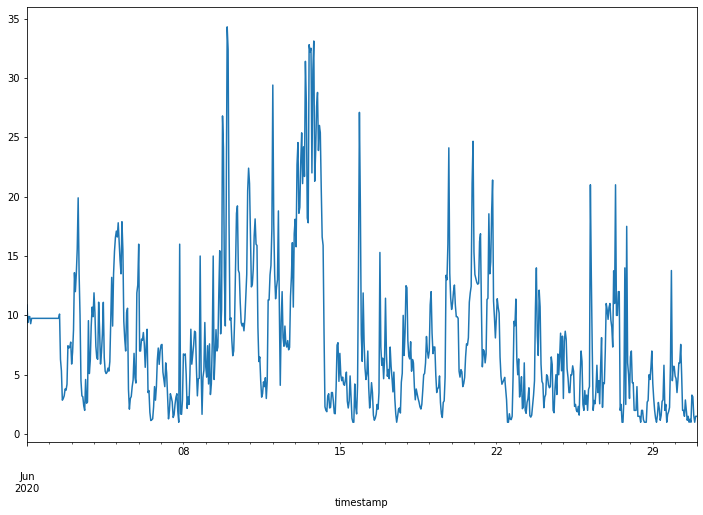

In [ ]:
air_hour.loc['2020-06-01':'2020-06-30']['PM25'].plot(figsize=(12, 8))

選擇一段想要使用的資料，將資料分為兩部分:

1.   訓練資料(train data): 用來訓練模型，也就是找出最適合模型的參數
2.   測試資料(test data): 訓練完模型後，會進行預測，如果要判斷預測結果是否準確則會使用測試資料做比較



In [ ]:
data_arima = air_hour.loc['2020-06-17':'2020-06-21']
train_len = -48
train = data_arima.iloc[:train_len]
test = data_arima.iloc[train_len:]

判斷這段資料是具有平穩性，並以差分的次數決定d參數的數值

In [ ]:
# train = train.diff().dropna()
# Run Dicky-Fuller test
result = adfuller(train)

# Print test statistic
print('The test stastics:', result[0])

# Print p-value
print("The p-value:",result[1])

The test stastics: -3.1129543556288826
The p-value: 0.025609243615341074


ARIMA模型中剩下參數p、參數q要決定，比較簡單的方法就是將p、q能形成的組合帶入模型中再去判斷模型的好壞。

要判斷要判斷模型的好壞可以使用可以使用AIC、、BIC，他們是判斷模型跟訓練資料是否擬合的方法，一般來說會選擇判斷出來數值比較小的模型比較小的模型。

以下先決定將p、q的範圍限制在限制在0~2之間，所以總共有有9種組合，查看每個模型aic與與bic的數值後即可決定參數。

In [ ]:
warnings.filterwarnings('ignore')
order_aic_bic =[]

# Loop over p values from 0-2
for p in range(3):
    # Loop over q values from 0-2
    for q in range(3):
      
        try:
            # create and fit ARMA(p,q) model
            model = sm.tsa.statespace.SARIMAX(train['PM25'], order=(p, 0, q))
            results = model.fit()
            
            # Print order and results
            order_aic_bic.append((p, q, results.aic, results.bic))            
        except:
            print(p, q, None, None)
            
# Make DataFrame of model order and AIC/BIC scores
order_df = pd.DataFrame(order_aic_bic, columns=['p', 'q', 'aic','bic'])

# lets sort them by AIC and BIC

# Sort by AIC
print("Sorted by AIC ")
# print("\n")
print(order_df.sort_values('aic').reset_index(drop=True))

# Sort by BIC
print("Sorted by BIC ")
# print("\n")
print(order_df.sort_values('bic').reset_index(drop=True))

Sorted by AIC 
   p  q         aic         bic
0  1  0  349.493661  354.046993
1  1  1  351.245734  358.075732
2  2  0  351.299268  358.129267
3  1  2  352.357930  361.464594
4  2  1  353.015921  362.122586
5  2  2  353.063243  364.446574
6  0  2  402.213407  409.043405
7  0  1  427.433962  431.987294
8  0  0  493.148188  495.424854
Sorted by BIC 
   p  q         aic         bic
0  1  0  349.493661  354.046993
1  1  1  351.245734  358.075732
2  2  0  351.299268  358.129267
3  1  2  352.357930  361.464594
4  2  1  353.015921  362.122586
5  2  2  353.063243  364.446574
6  0  2  402.213407  409.043405
7  0  1  427.433962  431.987294
8  0  0  493.148188  495.424854


決定好p、d、q三個參數後就可以來訓練模型

                               SARIMAX Results                                
Dep. Variable:                   PM25   No. Observations:                   72
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -168.853
Date:                Fri, 26 Aug 2022   AIC                            343.706
Time:                        05:01:13   BIC                            350.536
Sample:                    06-17-2020   HQIC                           346.425
                         - 06-19-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.3774      1.959      3.255      0.001       2.537      10.218
ar.L1          0.7792      0.047     16.584      0.000       0.687       0.871
sigma2         6.2934      0.746      8.438      0.0

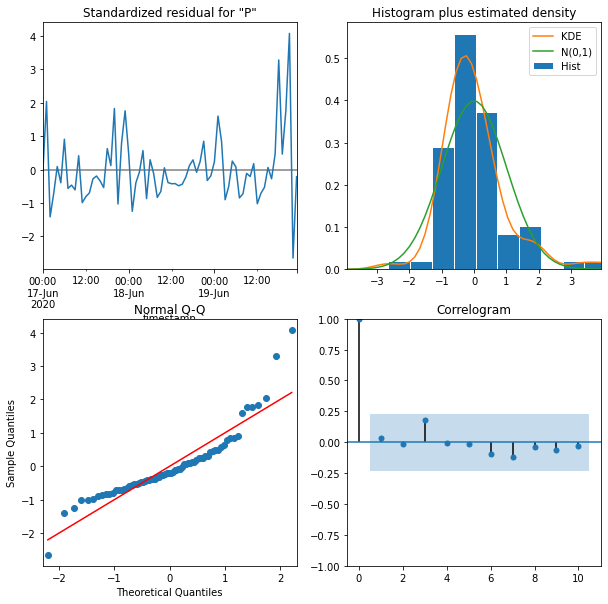

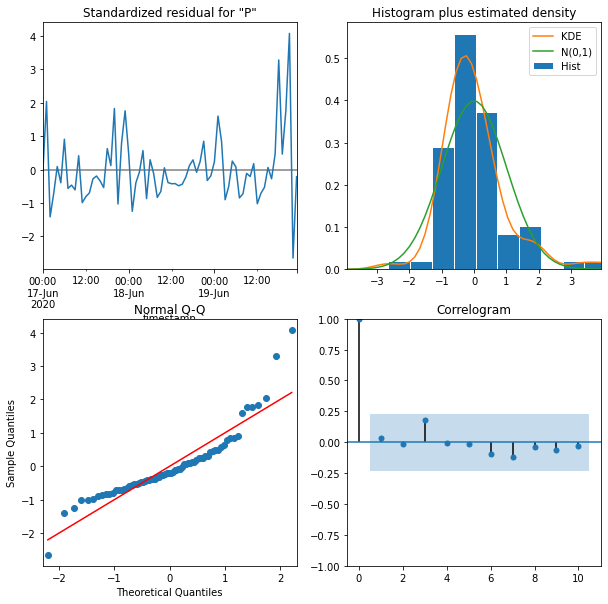

In [ ]:
# Instantiate model object
model = ARIMA(train, order=(1,0,0))

# Fit model
results = model.fit()
print(results.summary())
results.plot_diagnostics(figsize=(10, 10))

接著預測結果並畫圖跟測試資料比較，但目前預測出來的曲線太過平滑，似乎跟實際上的數值差很大。
那先觀察整段資料，會發現資料有規律的起伏，這就是資料的週期性，而ARIMA只能預測出資料的趨勢，因此我們要使用SARIMAX，也就是也就是ARIMA再延伸的模型。

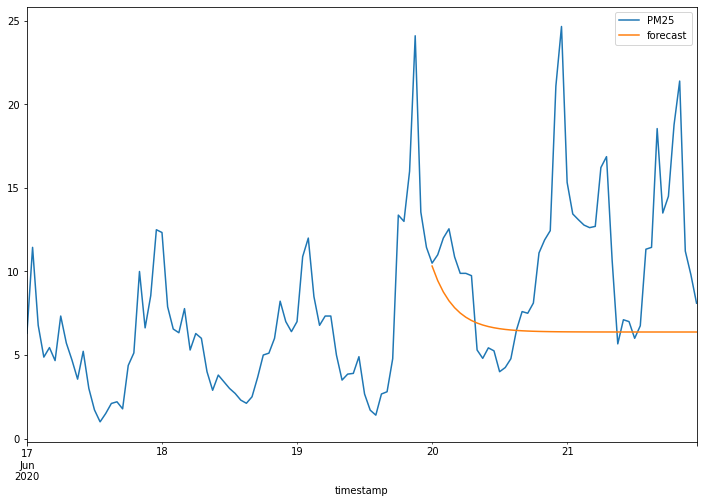

In [ ]:
data_arima['forecast'] = results.predict(start=24*5-48, end=24*5)
data_arima[['PM25', 'forecast']].plot(figsize=(12, 8))

## SARIMAX

In [ ]:
data_sarimax = air_hour.loc['2020-06-17':'2020-06-21']
train_len = -48
train = data_sarimax.iloc[:train_len]
test = data_sarimax.iloc[train_len:]

SARIMAX的參數變為七個，分別是p, d, q, P, D, Q, s，這些參數可以分為兩組，order=(p, d, q)這三個參數跟ARIMA的參數一樣，另一組是seasonal_order=(P, D, Q, s)，也就是週期性的AR模型參數、週期性的差分次數、週期性的MA模型參數，最後再加上一個週期性長度的參數。

參數                | 說明
-------------------|------------------
p                  | AR模型參數 
d                  | 達到平穩性所需要的差分次數
q                  | MA模型參數
P                  | 週期性的AR模型參數 
D                  | 週期上達到平穩性所需要的差分次數
Q                  | 週期性的MA模型參數
s                  | 週期長度

因爲觀察上圖可以看出這斷資料大約大約24小時會有一個週期所以讓s=24

                                     SARIMAX Results                                      
Dep. Variable:                               PM25   No. Observations:                   72
Model:             SARIMAX(1, 0, 0)x(0, 1, 0, 24)   Log Likelihood                -121.463
Date:                            Fri, 26 Aug 2022   AIC                            246.926
Time:                                    05:01:26   BIC                            250.669
Sample:                                06-17-2020   HQIC                           248.341
                                     - 06-19-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6683      0.069      9.698      0.000       0.533       0.803
sigma2         9.1224      1.426   

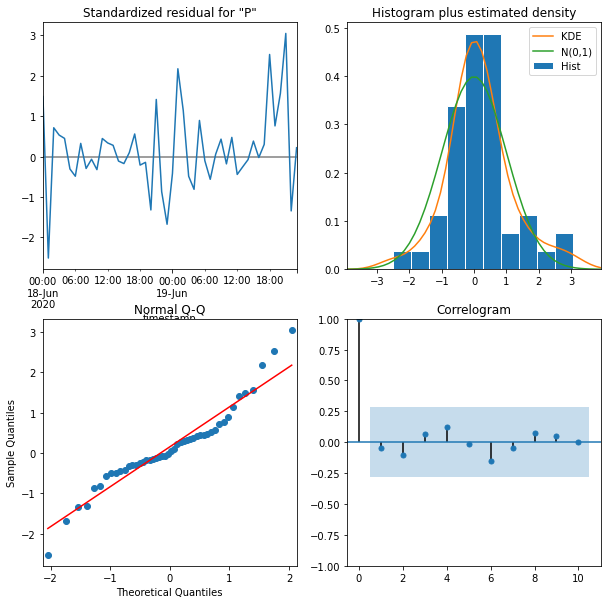

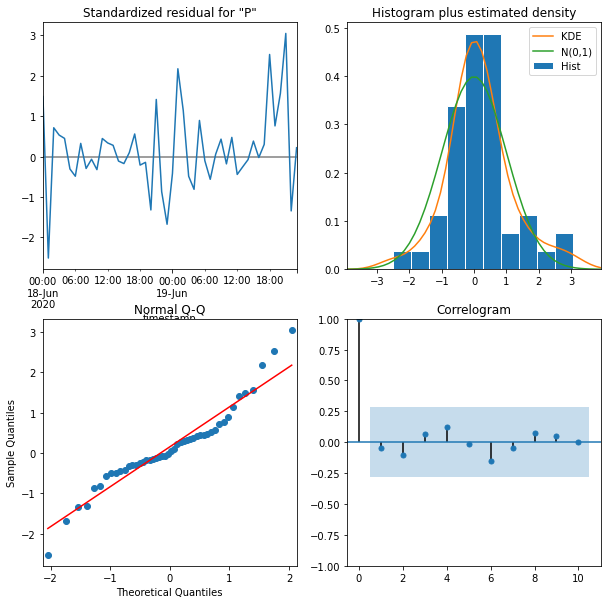

In [ ]:
# Instantiate model object
model = SARIMAX(train, order=(1,0,0), seasonal_order=(0, 1, 0, 24))

# Fit model
results = model.fit()
print(results.summary())
results.plot_diagnostics(figsize=(10, 10))

接下來將預測的數值與資料一起作圖，這次可以看到預測出來的橘色線蠻貼近實際的數值了

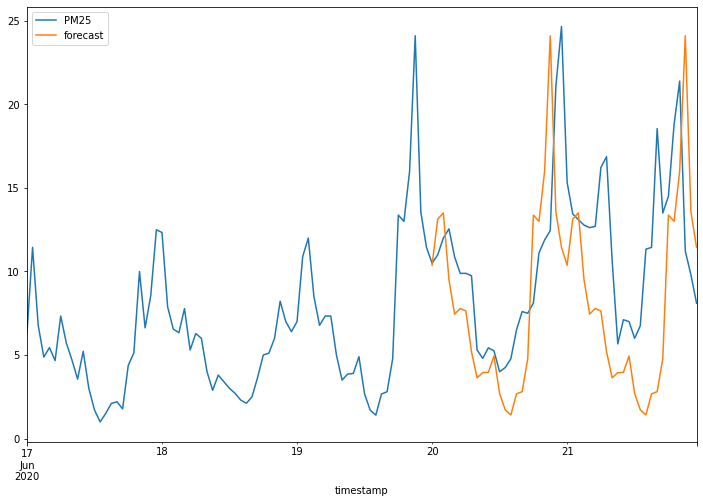

In [ ]:
data_sarimax['forecast'] = results.predict(start=24*5-48, end=24*5)
data_sarimax[['PM25', 'forecast']].plot(figsize=(12, 8))

但有時候可能很難找到對的參數，因此下一部分將會介紹怎麼自動找出適當的參數

## auto_arima

pmdarima是一個套件，目的是讓python語言也有像Ｒ語言中的auto.arima模型可以用

而pmdarima.ARIMA其實是包括包括ARMA、ARIMA、SARIMAX這三種模型

此外還有pmdarima.auto_arima提供尋找參數p, q, P, Q的方法，只要提供參數的範圍，就會在這個範圍中找出最適合的參數

一開始一樣將資料分為訓練資料與預測資料

In [ ]:
data_autoarima = air_hour.loc['2020-06-17':'2020-06-21']
train_len = -48
train = data_autoarima.iloc[:train_len]
test = data_autoarima.iloc[train_len:]

使用auto_arima尋找適合的參數，可以看到p, q, P, Q這四個參數都有start、max，代表這四個參數的範圍，而m是週期性，同時也要讓seasonal=True

In [ ]:
results = pm.auto_arima(train,start_p=0, d=0, start_q=0, max_p=5, max_d=5, max_q=5, start_P=0, D=1, start_Q=0, max_P=5, max_D=5, max_Q=5, m=24, seasonal=True, error_action='warn', trace = True, supress_warnings=True, stepwise = True, random_state=20, n_fits = 20)
print(results.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[24] intercept   : AIC=268.023, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[24] intercept   : AIC=247.639, Time=0.85 sec
 ARIMA(0,0,1)(0,1,1)[24] intercept   : AIC=250.711, Time=0.79 sec
 ARIMA(0,0,0)(0,1,0)[24]             : AIC=271.305, Time=0.04 sec
 ARIMA(1,0,0)(0,1,0)[24] intercept   : AIC=247.106, Time=0.09 sec
 ARIMA(1,0,0)(0,1,1)[24] intercept   : AIC=247.668, Time=0.45 sec
 ARIMA(1,0,0)(1,1,1)[24] intercept   : AIC=inf, Time=2.63 sec
 ARIMA(2,0,0)(0,1,0)[24] intercept   : AIC=249.013, Time=0.15 sec
 ARIMA(1,0,1)(0,1,0)[24] intercept   : AIC=248.924, Time=0.21 sec
 ARIMA(0,0,1)(0,1,0)[24] intercept   : AIC=250.901, Time=0.11 sec
 ARIMA(2,0,1)(0,1,0)[24] intercept   : AIC=250.579, Time=0.30 sec
 ARIMA(1,0,0)(0,1,0)[24]             : AIC=246.926, Time=0.06 sec
 ARIMA(1,0,0)(1,1,0)[24]             : AIC=247.866, Time=0.28 sec
 ARIMA(1,0,0)(0,1,1)[24]             : AIC=247.933, Time=0.31 sec
 ARIMA(1,0,0)(1,1,1)[24]             

將預測結果與原本的資料一起作圖，可以看到預測的數值雖然低了一點，但整體的變化算有預測到

In [ ]:
results.predict(n_periods=10)

2020-06-20 00:00:00    10.371336
2020-06-20 01:00:00    13.142043
2020-06-20 02:00:00    13.505843
2020-06-20 03:00:00     9.506395
2020-06-20 04:00:00     7.450378
2020-06-20 05:00:00     7.782850
2020-06-20 06:00:00     7.633757
2020-06-20 07:00:00     5.200781
2020-06-20 08:00:00     3.634188
2020-06-20 09:00:00     3.946824
Freq: H, dtype: float64

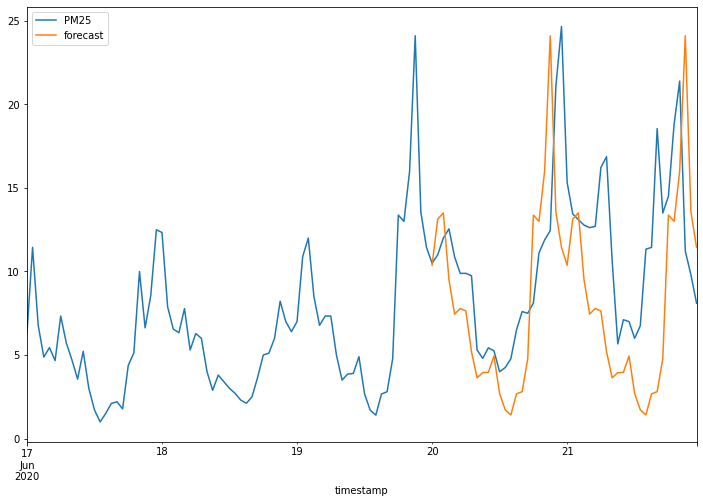

In [ ]:
data_autoarima['forecast'] = pd.DataFrame(results.predict(n_periods=48), index=test.index)
data_autoarima[['PM25', 'forecast']].plot(figsize=(12, 8))

以上是介紹ARIMA相關的模型，後續還會簡單介紹其他預測模型

## Prophet

Kats是一個用來處理時序資料很方便的套件，在4.1中將它用在資料檢測上，而在這個單元，我們會用到的是這個套件中的預測模型，第一個用的是Prophet

In [ ]:
# '2020-03-27':'2020-03-31' -24 additive
# '2020-06-10':'2020-06-17' -48 additive

先選擇要使用的資料區段，並將資料分成訓練資料與測試資料

再藉著作圖看看訓練資料的樣子

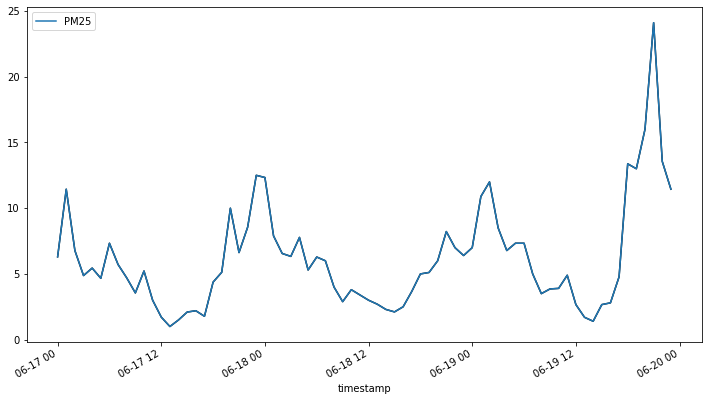

In [ ]:
data_prophet = air_hour.loc['2020-06-17':'2020-06-21']
train_len = -48
train = data_prophet.iloc[:train_len]
test = data_prophet.iloc[train_len:]

trainData = TimeSeriesData(train.reset_index(), time_col_name='timestamp')
trainData.plot(cols=["PM25"])

依序設定模型的參數與選擇模型，這邊用的模型就是Prophet

接著就可以訓練模型並開始預測

In [ ]:
# Specify parameters
params = ProphetParams(seasonality_mode="multiplicative")

# Create a model instance
m = ProphetModel(trainData, params)

# Fit mode
m.fit()

# Forecast
fcst = m.predict(steps=48, freq="H")
data_prophet['forecast'] = fcst[['time','fcst']].set_index('time')
fcst

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


,time,fcst,fcst_lower,fcst_upper
0,2020-06-20 00:00:00,14.705192,12.268361,17.042476
1,2020-06-20 01:00:00,15.089580,12.625568,17.573396
2,2020-06-20 02:00:00,14.921077,12.459802,17.411335
3,2020-06-20 03:00:00,13.846131,11.444988,16.200284
4,2020-06-20 04:00:00,12.278140,9.863531,14.858334
5,2020-06-20 05:00:00,10.934739,8.372450,13.501025
6,2020-06-20 06:00:00,10.126712,7.654647,12.658054
7,2020-06-20 07:00:00,9.535067,7.034313,11.762639
8,2020-06-20 08:00:00,8.661877,6.255147,11.132732
9,2020-06-20 09:00:00,7.424133,5.055052,9.770750


In [ ]:
data_prophet

,PM25,forecast
timestamp,,
2020-06-17 00:00:00,6.300000,NaN
2020-06-17 01:00:00,11.444444,NaN
2020-06-17 02:00:00,6.777778,NaN
2020-06-17 03:00:00,4.875000,NaN
2020-06-17 04:00:00,5.444444,NaN
...,...,...
2020-06-21 19:00:00,18.777778,23.856724
2020-06-21 20:00:00,21.400000,27.746195
2020-06-21 21:00:00,11.222222,28.276321


將訓練資料(黑線)與預測資料(藍線)畫出來

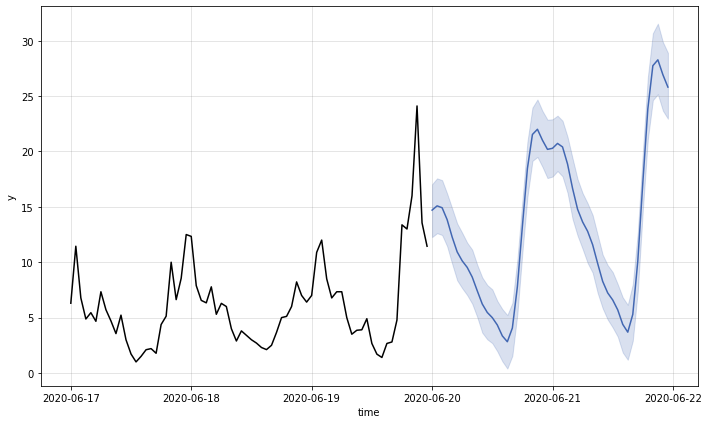

In [ ]:
m.plot()

為了看出預測結果準不準確，將測試資料也一起畫在圖上，可以看到藍色曲線算是貼合黑色曲線

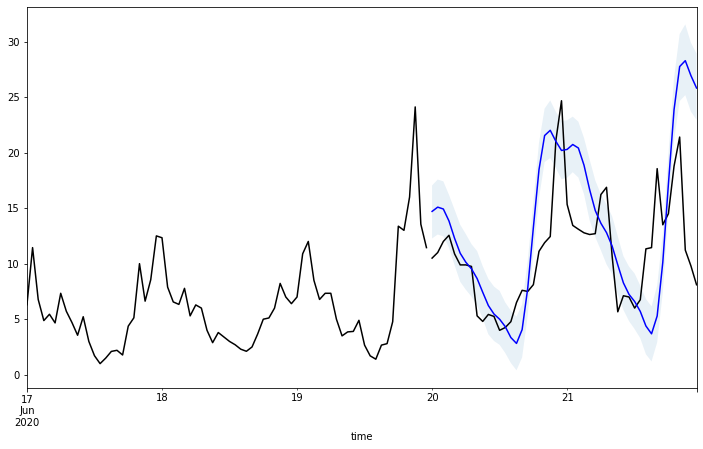

In [ ]:
fig, ax = plt.subplots(figsize=(12, 7))

train.plot(ax=ax, label='train', color='black')
test.plot(ax=ax, color='black')
fcst.plot(x='time', y='fcst', ax=ax, color='blue')

ax.fill_between(test.index, fcst['fcst_lower'], fcst['fcst_upper'], alpha=0.1)
ax.get_legend().remove()

## LSTM

LSTM(long short-term memory)是適合使用在連續的資料的預測模型，因為他會對不同時間的資料產生不同的長短期記憶，最後預測出結果。
而LSTM模型也已經在kats的預測模型中，所以我們可以直接使用，步驟也跟使用Prophet一樣

先將資料分為訓練資料與測試資料，並畫圖查看訓練資料

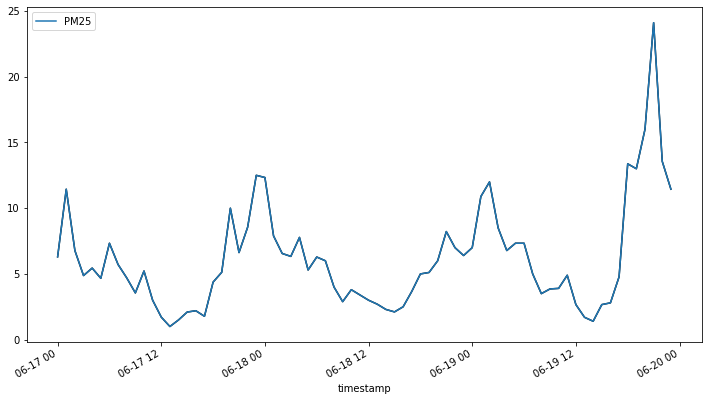

In [ ]:

data_lstm = air_hour.loc['2020-06-17':'2020-06-21']
train_len = -48
train = data_lstm.iloc[:train_len]
test = data_lstm.iloc[train_len:]

trainData = TimeSeriesData(train.reset_index(), time_col_name='timestamp')
trainData.plot(cols=["PM25"])

依序選擇參數與訓練模型，因為LSTM是神經網路的模型，所以需要的參數有訓練次數(num_epochs), 一次讀入的資料時間長度(time_window), 還有跟長短期記憶比較有關的神經網路層數(hidden_size)，其實在kats中這些步驟都已經被簡化，所以只要以參數的部分決定就好。

接著就是訓練模型與預測

In [ ]:
# h=10 t=12 n=50 step=12

In [ ]:
params = LSTMParams(
    hidden_size=10, # number of hidden layers
    time_window=24,
    num_epochs=30
)
m = LSTMModel(trainData, params)
m.fit()

fcst = m.predict(steps=48, freq="H")
data_lstm['forecast'] = fcst[['time', 'fcst']].set_index('time')
fcst

,time,fcst,fcst_lower,fcst_upper
0,2020-06-20 00:00:00,11.905971,11.310672,12.501269
1,2020-06-20 01:00:00,10.804338,10.264121,11.344554
2,2020-06-20 02:00:00,9.740741,9.253704,10.227778
3,2020-06-20 03:00:00,8.696406,8.261586,9.131226
4,2020-06-20 04:00:00,7.656923,7.274077,8.039769
5,2020-06-20 05:00:00,6.608442,6.278019,6.938864
6,2020-06-20 06:00:00,5.543790,5.266600,5.820979
7,2020-06-20 07:00:00,4.469023,4.245572,4.692474
8,2020-06-20 08:00:00,3.408312,3.237897,3.578728
9,2020-06-20 09:00:00,2.411980,2.291381,2.532578


先將訓練資料與預測資料作圖

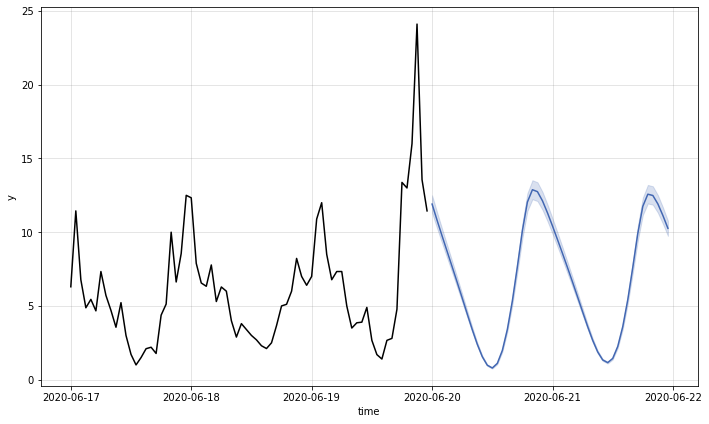

In [ ]:
m.plot()

再將測試資料一起作圖，查看預測資料著準確性

查看下圖後，可以發現預測結果接近測試資料

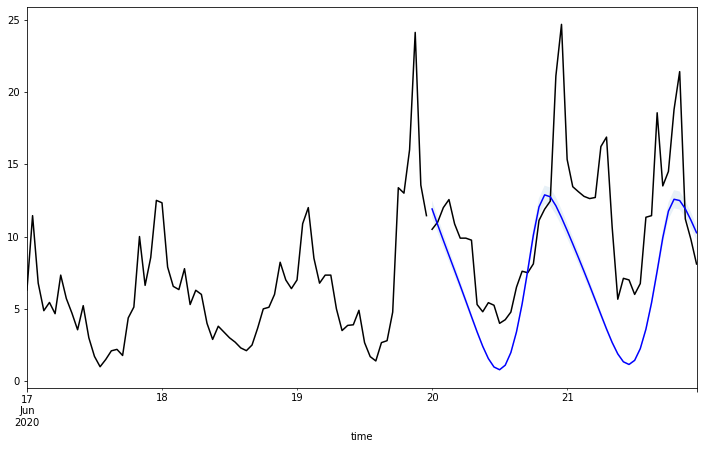

In [ ]:
fig, ax = plt.subplots(figsize=(12, 7))

train.plot(ax=ax, label='train', color='black')
test.plot(ax=ax, color='black')
fcst.plot(x='time', y='fcst', ax=ax, color='blue')

ax.fill_between(test.index, fcst['fcst_lower'], fcst['fcst_upper'], alpha=0.1)
ax.get_legend().remove()

## Holt-Winter

Holt-Winter模型是利用移動平均的概念，分配歷史資料的權重，達到預測的目的

一樣先將資料分為訓練資料與測試資料

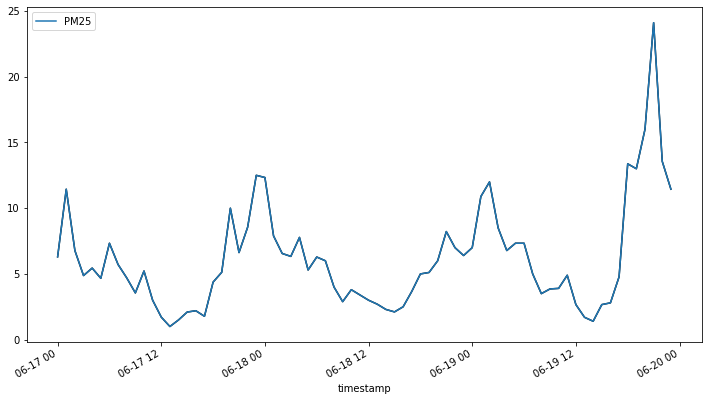

In [ ]:
data_hw = air_hour.loc['2020-06-17':'2020-06-21']
train_len = -48
train = data_hw.iloc[:train_len]
test = data_hw.iloc[train_len:]

trainData = TimeSeriesData(train.reset_index(), time_col_name='timestamp')
trainData.plot(cols=["PM25"])

依序選擇參數與模型，holt-winter模型的參數主要是包括選擇該用加法或乘法分解時序資料，以及週期性的長度。

接著開始訓練模型以及進行預測

In [ ]:
warnings.simplefilter(action='ignore')

# Specify parameters
params = HoltWintersParams(
            trend="mul",
            seasonal="mul",
            seasonal_periods=24,
        )

# Create a model instance
m = HoltWintersModel(
    data=trainData, 
    params=params)

# Fit mode
m.fit()

# Forecast
fcst = m.predict(steps=48, freq='H')
data_hw['forecast'] = fcst[['time', 'fcst']].set_index('time')
fcst

,time,fcst
72,2020-06-20 00:00:00,14.140232
73,2020-06-20 01:00:00,14.571588
74,2020-06-20 02:00:00,12.797056
75,2020-06-20 03:00:00,10.061594
76,2020-06-20 04:00:00,9.927476
77,2020-06-20 05:00:00,8.732691
78,2020-06-20 06:00:00,10.257460
79,2020-06-20 07:00:00,8.169070
80,2020-06-20 08:00:00,6.005400
81,2020-06-20 09:00:00,5.038056


將訓練資料與預測資料作圖

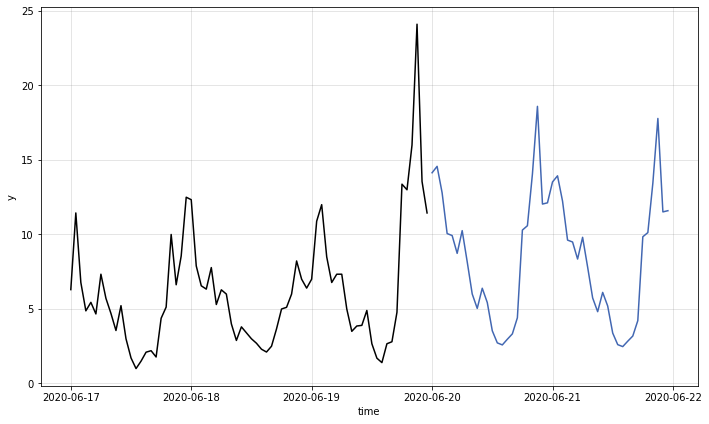

In [ ]:
m.plot()

為了查看預測準確度，也將測試資料作圖。

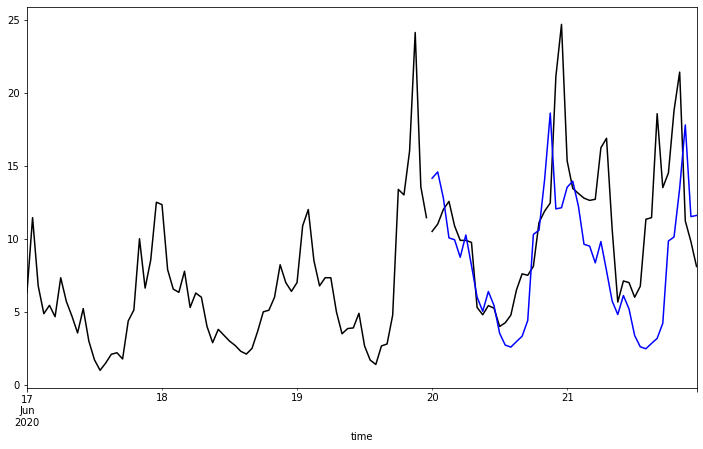

In [ ]:
fig, ax = plt.subplots(figsize=(12, 7))

train.plot(ax=ax, label='train', color='black')
test.plot(ax=ax, color='black')
fcst.plot(x='time', y='fcst', ax=ax, color='blue')

# ax.fill_between(test.index, fcst['fcst_lower'], fcst['fcst_upper'], alpha=0.1)
ax.get_legend().remove()

## 比較各種模型

以上就是這單元介紹的預測模型，可以從下方的六張圖比較各種模型的預測效果（要先跑過上面所有預測模型的程式碼才看得到六張圖）

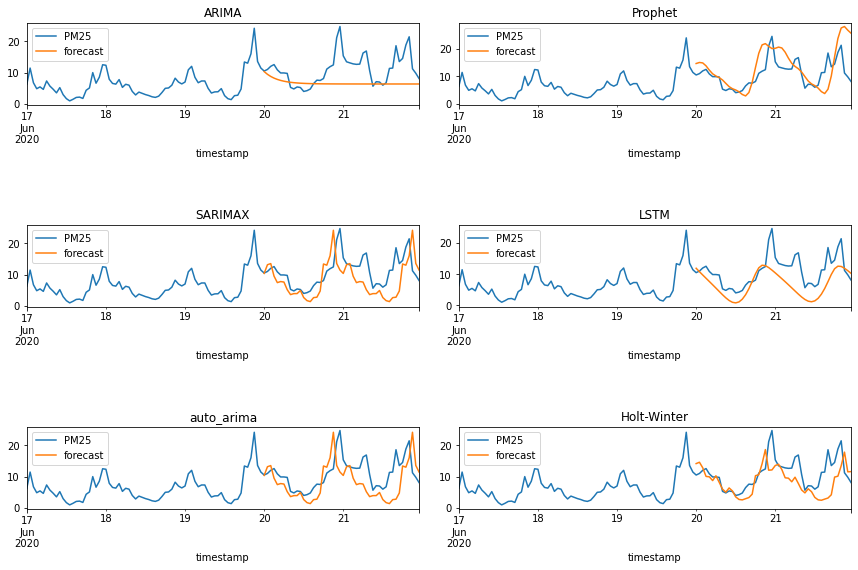

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 8))


data_arima[['PM25', 'forecast']].plot(ax=axes[0, 0], title='ARIMA')
data_sarimax[['PM25', 'forecast']].plot(ax=axes[1, 0], title='SARIMAX')
data_autoarima[['PM25', 'forecast']].plot(ax=axes[2, 0], title='auto_arima')
data_prophet[['PM25', 'forecast']].plot(ax=axes[0, 1], title='Prophet')
data_lstm[['PM25', 'forecast']].plot(ax=axes[1, 1], title='LSTM')
data_hw[['PM25', 'forecast']].plot(ax=axes[2, 1], title='Holt-Winter')

fig.tight_layout(pad=1, w_pad=2, h_pad=5)

# 以下省略

## Skforecast

In [ ]:
!pip install -U scikit-learn skforecast

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster

In [ ]:
# '2020-06-17':'2020-06-20' max_depth=5, n_estimators=100, random_state=123 lags = 20
# '2020-06-14':'2020-06-18' max_depth=5, n_estimators=500, random_state=123 lags = 20

In [ ]:
data = air_hour.loc['2020-06-17':'2020-06-20']
train_len = -48
train = data.iloc[:train_len]
test = data.iloc[train_len:]

# trainData = TimeSeriesData(train.reset_index(), time_col_name='timestamp')
# trainData.plot(cols=["PM25"])

In [ ]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(max_depth=5, n_estimators=500, random_state=123),
                lags = 20
                )

forecaster.fit(y=train['PM25'])
forecaster

In [ ]:
# Predictions
# ==============================================================================
steps = 48
predictions = forecaster.predict(steps=steps)
predictions.head(5)

In [ ]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
train['PM25'].plot(ax=ax, label='train')
test['PM25'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [ ]:
# Hyperparameter Grid search
# ==============================================================================
steps = 24
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 15 # This value will be replaced in the grid search
             )

# Lags used as predictors
lags_grid = [10, 20]

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = train['PM25'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )

In [ ]:
# Grid Search results
# ==============================================================================
results_grid